In [39]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import sklearn
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image
from keras.callbacks import EarlyStopping
import numpy as np
from sklearn.model_selection import train_test_split

import warnings
import os
import glob
warnings.filterwarnings("ignore")
import cv2
from pathlib import Path
# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "autoencoders"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Using TensorFlow backend.


In [0]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

In [0]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

## Acquiring the data 
- Keras provides some utility functions to fetch and load common datasets.
- Lets load the Fashion MNIST dataset-loading Fashion MNIST using keras represents every image as a 28*28 array rather than as a 1D array.


In [0]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

4423680/4422102 [==============================] - 0s 0us/step


In [0]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

- Some samples from the Fashion MNIST dataset

Saving figure fashion_mnist_plot


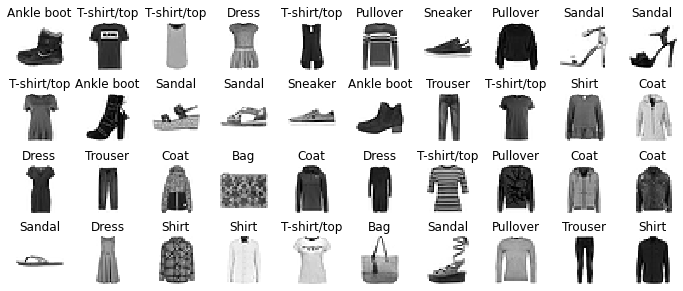

In [0]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_plot', tight_layout=False)
plt.show()

In [0]:
def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

- The autoencoder consists of two components :the encoder and the decoder.
- The encoder converts the inputs to latent representation and the decoder which reconstructs the data based on the internal representation.
- Here the encoder takes a 28*28 pixel gray scale images, flattens them and processes these vectors through two Dense layers of dimnishing sizes.
- The decoder takes the output of the encoder and processes them through two Dense layers of increasing sizes,and reshapes the final vectors into 28*28 arrays.

In [0]:
stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu"),
])
stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss="binary_crossentropy",
                   optimizer=keras.optimizers.SGD(lr=1.5), metrics=[rounded_accuracy])
history = stacked_ae.fit(X_train, X_train, epochs=20,
                         validation_data=[X_valid])

Epoch 1/20
1719/1719 [==============================] - 4s 3ms/step - loss: 0.3381 - rounded_accuracy: 0.8870 - val_loss: 0.0000e+00 - val_rounded_accuracy: 0.0000e+00
Epoch 2/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3056 - rounded_accuracy: 0.9152 - val_loss: 0.0000e+00 - val_rounded_accuracy: 0.0000e+00
Epoch 3/20
1719/1719 [==============================] - 4s 3ms/step - loss: 0.2986 - rounded_accuracy: 0.9215 - val_loss: 0.0000e+00 - val_rounded_accuracy: 0.0000e+00
Epoch 4/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2948 - rounded_accuracy: 0.9249 - val_loss: 0.0000e+00 - val_rounded_accuracy: 0.0000e+00
Epoch 5/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2923 - rounded_accuracy: 0.9272 - val_loss: 0.0000e+00 - val_rounded_accuracy: 0.0000e+00
Epoch 6/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2904 - rounded_accuracy: 0.9289 - val_loss: 0.0000e+00 - val_rounded_accuracy: 0.0

- The reconstructions are similar,we can train the model for longer,or make the encoder and decoder deeper to better the reconstruction losses

Saving figure reconstruction_plot


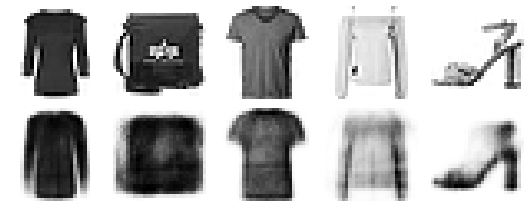

In [0]:
show_reconstructions(stacked_ae)
save_fig("reconstruction_plot")

## Dimensionality reduction for data visualization
- For 2D visualization specifically, t-SNE , it requires relatively low-dimensional data. So a good strategy is to use an autoencoder to compress your data into a low-dimensional space,then use t-SNE for mapping the compressed data to a 2D plane.
- first we use an encoder to reduce the dimensionality down to 30 and the use t-sne algorithm to reduce the dimensionality down to 2.

In [0]:
from sklearn.manifold import TSNE 

X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)
X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())

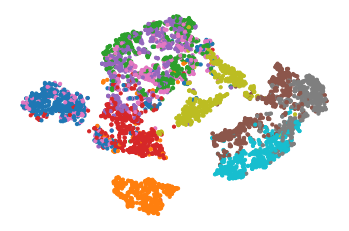

In [0]:
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap="tab10")
plt.axis("off")
plt.show()

Saving figure fashion_mnist_visualization_plot


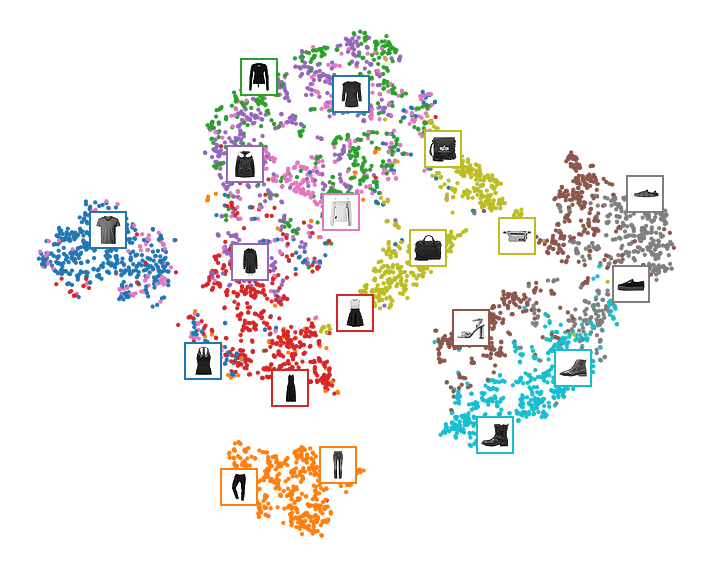

In [0]:
# adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_valid_2D):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")
save_fig("fashion_mnist_visualization_plot")
plt.show()

## Sparse Autoencoder
Here we constrain the representations to be compact by adding a sparsity constraint on the activity of the hidden representations.


we add l1 regularization to the coding layer:

In [40]:
sparse_l1_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(300, activation="sigmoid",activity_regularizer=keras.regularizers.l1(1e-3))
])
sparse_l1_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[300]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
sparse_l1_ae = keras.models.Sequential([sparse_l1_encoder, sparse_l1_decoder])
sparse_l1_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                     metrics=[rounded_accuracy])
history = sparse_l1_ae.fit(X_train, X_train, epochs=10,
                           validation_data=[X_valid])

Epoch 1/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4326 - rounded_accuracy: 0.8118 - val_loss: 0.0110 - val_rounded_accuracy: 0.0000e+00
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3696 - rounded_accuracy: 0.8675 - val_loss: 0.0082 - val_rounded_accuracy: 0.0000e+00
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3542 - rounded_accuracy: 0.8803 - val_loss: 0.0075 - val_rounded_accuracy: 0.0000e+00
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3427 - rounded_accuracy: 0.8887 - val_loss: 0.0072 - val_rounded_accuracy: 0.0000e+00
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3358 - rounded_accuracy: 0.8939 - val_loss: 0.0069 - val_rounded_accuracy: 0.0000e+00
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3308 - rounded_accuracy: 0.8979 - val_loss: 0.0064 - val_rounded_accuracy: 0.0000e+00
Epoch 7/10
1719/

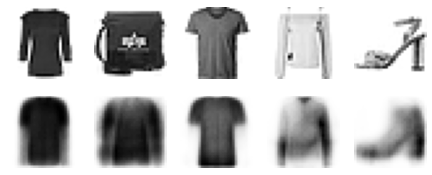

In [41]:
show_reconstructions(sparse_l1_ae)

In [0]:
K = keras.backend
kl_divergence = keras.losses.kullback_leibler_divergence

class KLDivergenceRegularizer(keras.regularizers.Regularizer):
    def __init__(self, weight, target=0.1):
        self.weight = weight
        self.target = target
    def __call__(self, inputs):
        mean_activities = K.mean(inputs, axis=0)
        return self.weight * (
            kl_divergence(self.target, mean_activities) +
            kl_divergence(1. - self.target, 1. - mean_activities))

In [43]:
kld_reg = KLDivergenceRegularizer(weight=0.05, target=0.1)
sparse_kl_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(300, activation="sigmoid", activity_regularizer=kld_reg)
])
sparse_kl_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[300]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
sparse_kl_ae = keras.models.Sequential([sparse_kl_encoder, sparse_kl_decoder])
sparse_kl_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
              metrics=[rounded_accuracy])
history = sparse_kl_ae.fit(X_train, X_train, epochs=10,
                           validation_data=[X_valid])

Epoch 1/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4170 - rounded_accuracy: 0.8097 - val_loss: 0.0029 - val_rounded_accuracy: 0.0000e+00
Epoch 2/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3522 - rounded_accuracy: 0.8771 - val_loss: 0.0025 - val_rounded_accuracy: 0.0000e+00
Epoch 3/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3327 - rounded_accuracy: 0.8934 - val_loss: 0.0025 - val_rounded_accuracy: 0.0000e+00
Epoch 4/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3218 - rounded_accuracy: 0.9025 - val_loss: 0.0023 - val_rounded_accuracy: 0.0000e+00
Epoch 5/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3168 - rounded_accuracy: 0.9065 - val_loss: 0.0024 - val_rounded_accuracy: 0.0000e+00
Epoch 6/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3133 - rounded_accuracy: 0.9095 - val_loss: 0.0022 - val_rounded_accuracy: 0.0000e+00
Epoch 7/10
1719/

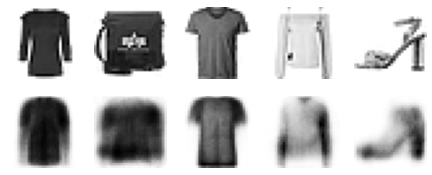

In [44]:
show_reconstructions(sparse_kl_ae)

##  Convolutional autoencoder
- Since we are dealing with images it makes more sense to use convolutional neural networks as encoders and decoders.
- The encoder will consist of regular convultional layers and pooling layers,Maxpooling is used for spatial down-sampling.
- The decoder does the reverse it upscales the images,for this purpose we use transpose convolutional layers.

In [45]:
conv_encoder = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2)
])
conv_decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="VALID", activation="selu",
                                 input_shape=[3, 3, 64]),
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="SAME", activation="selu"),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="SAME", activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])

conv_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                metrics=[rounded_accuracy])
history = conv_ae.fit(X_train, X_train, epochs=5,
                      validation_data=[X_valid])

Epoch 1/5
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3012 - rounded_accuracy: 0.9189 - val_loss: 0.0000e+00 - val_rounded_accuracy: 0.0000e+00
Epoch 2/5
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2757 - rounded_accuracy: 0.9412 - val_loss: 0.0000e+00 - val_rounded_accuracy: 0.0000e+00
Epoch 3/5
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2709 - rounded_accuracy: 0.9460 - val_loss: 0.0000e+00 - val_rounded_accuracy: 0.0000e+00
Epoch 4/5
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2682 - rounded_accuracy: 0.9488 - val_loss: 0.0000e+00 - val_rounded_accuracy: 0.0000e+00
Epoch 5/5
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2664 - rounded_accuracy: 0.9508 - val_loss: 0.0000e+00 - val_rounded_accuracy: 0.0000e+00


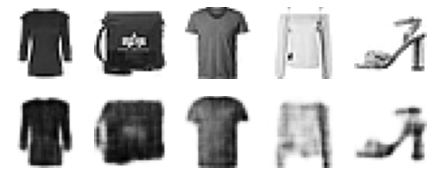

In [46]:
show_reconstructions(conv_ae)
plt.show()

## Stacked denoising Autoencoder
Another application of autoencoders is to work on image denoising problem.

- Here we will train the autoencoder to map noisy images to clean images.
- We can generate synthetic noisy images with an additional Dropout layer to the encoder's inputs or apply  a gaussian noise matrix as shown below.

In [0]:
noise_factor = 0.5
X_train_noisy = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape) 
X_valid_noisy = X_valid + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_valid.shape) 

X_train_noisy = np.clip(X_train_noisy, 0., 1.)
X_valid_noisy = np.clip(X_valid_noisy, 0., 1.)

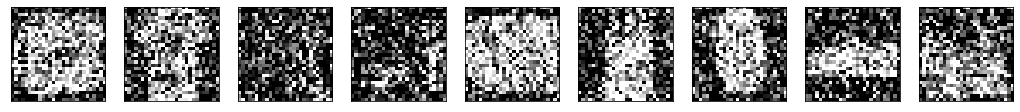

In [48]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(1,n):
    ax = plt.subplot(1, n, i)
    plt.imshow(X_valid_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


In [49]:
dropout_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])
dropout_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
dropout_ae = keras.models.Sequential([dropout_encoder, dropout_decoder])
dropout_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                   metrics=[rounded_accuracy])
history = dropout_ae.fit(X_train, X_train, epochs=10,
                         validation_data=[X_valid])

Epoch 1/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.3555 - rounded_accuracy: 0.8714 - val_loss: 0.0000e+00 - val_rounded_accuracy: 0.0000e+00
Epoch 2/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.3181 - rounded_accuracy: 0.9031 - val_loss: 0.0000e+00 - val_rounded_accuracy: 0.0000e+00
Epoch 3/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3113 - rounded_accuracy: 0.9086 - val_loss: 0.0000e+00 - val_rounded_accuracy: 0.0000e+00
Epoch 4/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3077 - rounded_accuracy: 0.9116 - val_loss: 0.0000e+00 - val_rounded_accuracy: 0.0000e+00
Epoch 5/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3052 - rounded_accuracy: 0.9137 - val_loss: 0.0000e+00 - val_rounded_accuracy: 0.0000e+00
Epoch 6/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3033 - rounded_accuracy: 0.9153 - val_loss: 0.0000e+00 - val_rounded_accuracy: 0.0

Saving figure dropout_denoising_plot


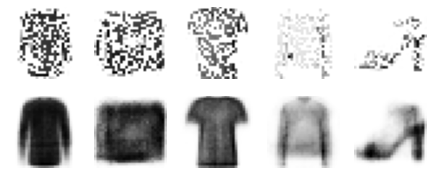

In [50]:
dropout = keras.layers.Dropout(0.5)
show_reconstructions(dropout_ae, dropout(X_valid, training=True))
save_fig("dropout_denoising_plot", tight_layout=False)

## Denoising images of scanned documents

Here we we denoise the images of scanned documents which contain creases and dark regions and make them more legible.

In [0]:
train_img = glob.glob('drive/My Drive/Autoencoders/denoising-dirty-documents/train/*.png')
clean_img = glob.glob('drive/My Drive/Autoencoders/denoising-dirty-documents/train_cleaned/*.png')
test_img = glob.glob('drive/My Drive/Autoencoders/denoising-dirty-documents/test/*.png')

In [62]:
def load_image(path):
    image_list = np.zeros((len(path), 258, 540, 1))
    for i, fig in enumerate(path):
        img = image.load_img(fig, grayscale=True, target_size=(258, 540))
        x = image.img_to_array(img).astype('float32')
        x = x / 255.0
        image_list[i] = x
    
    return image_list

x_train = load_image(train_img)
y_train = load_image(clean_img)
x_test = load_image(test_img)

print(x_train.shape, x_test.shape)

(144, 258, 540, 1) (72, 258, 540, 1)


In [63]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.15)
print(x_train.shape, x_val.shape)

(122, 258, 540, 1) (22, 258, 540, 1)


Sample images from the document.

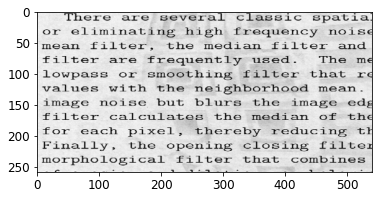

In [64]:
plt.imshow(x_train[0, :, :, 0])

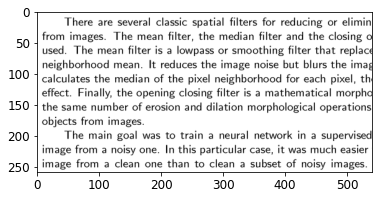

In [65]:
plt.imshow(y_train[0, :, :, 0])

In [66]:
#Encoder
conv_encoder = keras.models.Sequential([
keras.layers.Conv2D(64,kernel_size=3,activation='selu',padding='same',input_shape=[258,540,1]),
keras.layers.MaxPool2D(pool_size=2,padding='same')
])

#Decoder
conv_decoder = keras.models.Sequential([
keras.layers.Conv2DTranspose(64,(3,3),strides=2, padding="same", activation="selu",input_shape=[129, 270, 64]),
keras.layers.Conv2D(1,(3,3), padding="SAME", activation="sigmoid")    
])
text_ae = keras.models.Sequential([conv_encoder, conv_decoder])
text_ae.compile(optimizer='adam',loss='mse')
text_ae.summary()

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_36 (Sequential)   (None, 129, 270, 64)      640       
_________________________________________________________________
sequential_37 (Sequential)   (None, 258, 540, 1)       37505     
Total params: 38,145
Trainable params: 38,145
Non-trainable params: 0
_________________________________________________________________


In [67]:
batch_size = 16
epochs = 20
early_stopping = EarlyStopping(monitor='val_loss',min_delta=0,patience=5,verbose=1, mode='auto')
history = text_ae.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val, y_val))

Epoch 1/20
8/8 [==============================] - 2s 261ms/step - loss: 0.1105 - val_loss: 0.0700
Epoch 2/20
8/8 [==============================] - 2s 253ms/step - loss: 0.0755 - val_loss: 0.0759
Epoch 3/20
8/8 [==============================] - 2s 255ms/step - loss: 0.0771 - val_loss: 0.0737
Epoch 4/20
8/8 [==============================] - 2s 253ms/step - loss: 0.0729 - val_loss: 0.0691
Epoch 5/20
8/8 [==============================] - 2s 254ms/step - loss: 0.0709 - val_loss: 0.0682
Epoch 6/20
8/8 [==============================] - 2s 254ms/step - loss: 0.0700 - val_loss: 0.0680
Epoch 7/20
8/8 [==============================] - 2s 253ms/step - loss: 0.0698 - val_loss: 0.0675
Epoch 8/20
8/8 [==============================] - 2s 255ms/step - loss: 0.0690 - val_loss: 0.0674
Epoch 9/20
8/8 [==============================] - 2s 257ms/step - loss: 0.0691 - val_loss: 0.0672
Epoch 10/20
8/8 [==============================] - 2s 255ms/step - loss: 0.0689 - val_loss: 0.0670
Epoch 11/20
8/8 [==

In [0]:
preds = text_ae.predict(x_test)

Saving figure denoising_scanned_documents_input


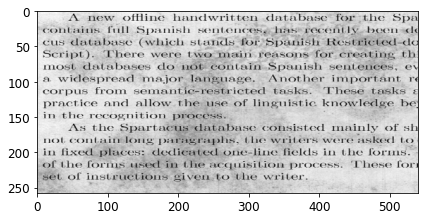

In [69]:
n = 25
preds_0 = preds[n] * 255.0
preds_0 = preds_0.reshape(258, 540)
x_test_0 = x_test[n] * 255.0
x_test_0 = x_test_0.reshape(258, 540)
plt.imshow(x_test_0,cmap='gray')
save_fig("denoising_scanned_documents_input")

Saving figure denoising_scanned_documents_generated_output


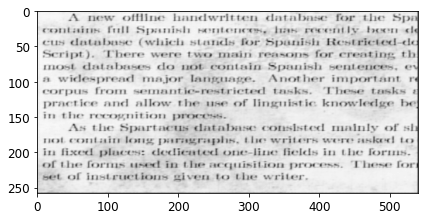

In [70]:
plt.imshow(preds_0,cmap='gray')
save_fig("denoising_scanned_documents_generated_output")

## Sequence to sequence autoencoder
- This type of autoencoder can be usefull when working with time series or text.
- The encoder acts as a sequence to vector RNN and the decoder acts as a vector to sequence RNN.

In [51]:
recurrent_encoder = keras.models.Sequential([
    keras.layers.LSTM(100, return_sequences=True, input_shape=[28, 28]),
    keras.layers.LSTM(30)
])
recurrent_decoder = keras.models.Sequential([
    keras.layers.RepeatVector(28, input_shape=[30]),
    keras.layers.LSTM(100, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(28, activation="sigmoid"))
])
recurrent_ae = keras.models.Sequential([recurrent_encoder, recurrent_decoder])
recurrent_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(0.1),
                     metrics=[rounded_accuracy])
history = recurrent_ae.fit(X_train, X_train, epochs=10, validation_data=[X_valid])

Epoch 1/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.5035 - rounded_accuracy: 0.7640 - val_loss: 0.0000e+00 - val_rounded_accuracy: 0.0000e+00
Epoch 2/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.3968 - rounded_accuracy: 0.8459 - val_loss: 0.0000e+00 - val_rounded_accuracy: 0.0000e+00
Epoch 3/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.3639 - rounded_accuracy: 0.8705 - val_loss: 0.0000e+00 - val_rounded_accuracy: 0.0000e+00
Epoch 4/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.3523 - rounded_accuracy: 0.8795 - val_loss: 0.0000e+00 - val_rounded_accuracy: 0.0000e+00
Epoch 5/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.3434 - rounded_accuracy: 0.8861 - val_loss: 0.0000e+00 - val_rounded_accuracy: 0.0000e+00
Epoch 6/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.3360 - rounded_accuracy: 0.8911 - val_loss: 0.0000e+00 - val_rounded_accurac

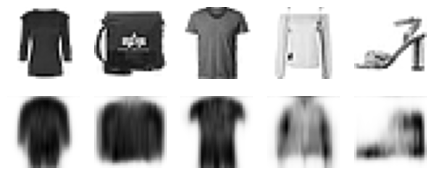

In [52]:
show_reconstructions(recurrent_ae)
plt.show()

## Variational autoencoder
- They are probabilistic autoencoders meaning instead of letting your neural network learn an arbitrary function,it learns parameters of a probability distribution modelling your data.
- Therefore, they can generate neew instances that look like they were sampled from the training set.
- Here the encoder produces a mean coding and a standard deviation.

In [0]:
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean 

In [57]:
codings_size = 10

inputs = keras.layers.Input(shape=[28,28])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150,activation='selu')(z)
z = keras.layers.Dense(100,activation='selu')(z)
codings_mean = keras.layers.Dense(codings_size)(z)
codings_log_var = keras.layers.Dense(codings_size)(z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = keras.models.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(100, activation="selu")(decoder_inputs)
x = keras.layers.Dense(150, activation="selu")(x)
x = keras.layers.Dense(28 * 28, activation="sigmoid")(x)
outputs = keras.layers.Reshape([28, 28])(x)
variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])

_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

latent_loss = -0.5 * K.sum(
    1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
    axis=-1)
variational_ae.add_loss(K.mean(latent_loss) / 784.)
variational_ae.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=[rounded_accuracy])
history = variational_ae.fit(X_train, X_train, epochs=25, batch_size=128,
                             validation_data=[X_valid])

Epoch 1/25
430/430 [==============================] - 2s 5ms/step - loss: 0.3875 - rounded_accuracy: 0.8619 - val_loss: 0.0216 - val_rounded_accuracy: 0.0000e+00
Epoch 2/25
430/430 [==============================] - 2s 5ms/step - loss: 0.3439 - rounded_accuracy: 0.8967 - val_loss: 0.0193 - val_rounded_accuracy: 0.0000e+00
Epoch 3/25
430/430 [==============================] - 2s 5ms/step - loss: 0.3332 - rounded_accuracy: 0.9048 - val_loss: 0.0184 - val_rounded_accuracy: 0.0000e+00
Epoch 4/25
430/430 [==============================] - 2s 5ms/step - loss: 0.3280 - rounded_accuracy: 0.9089 - val_loss: 0.0186 - val_rounded_accuracy: 0.0000e+00
Epoch 5/25
430/430 [==============================] - 2s 5ms/step - loss: 0.3248 - rounded_accuracy: 0.9114 - val_loss: 0.0182 - val_rounded_accuracy: 0.0000e+00
Epoch 6/25
430/430 [==============================] - 2s 5ms/step - loss: 0.3225 - rounded_accuracy: 0.9131 - val_loss: 0.0181 - val_rounded_accuracy: 0.0000e+00
Epoch 7/25
430/430 [========

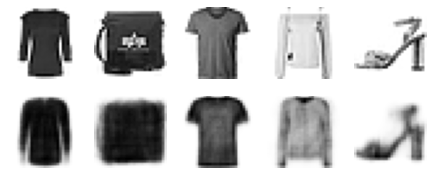

In [58]:
show_reconstructions(variational_ae)
plt.show()

In [0]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

we use variational autoencoder to generste images that look like fashion items

Saving figure vae_generated_images_plot


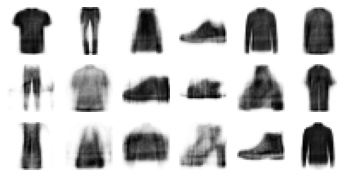

In [60]:
tf.random.set_seed(42)

codings = tf.random.normal(shape=[18, codings_size])
images = variational_decoder(codings).numpy()
plot_multiple_images(images, 6)
save_fig("vae_generated_images_plot", tight_layout=False)

## References
- https://blog.keras.io/building-autoencoders-in-keras.html
- https://github.com/mrdragonbear/Autoencoders/blob/master/Autoencoder-Tutorial.ipynb
- https://github.com/ageron/handson-ml2